<a href="https://colab.research.google.com/github/samikshasatokar/GANs/blob/main/Monochrome_Image_Colorization_using_Pix2Pix_GAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

In [ ]:
clr_path = "../content/drive/MyDrive/Px2Pix Image Colorisation/landscape Images/color/"
gry_path = "../content/drive/MyDrive/Px2Pix Image Colorisation/landscape Images/gray"

In [ ]:
import os

clr_img_path = []
gry_img_path = []

for img_path in os.listdir(clr_path) :
    clr_img_path.append(os.path.join(clr_path, img_path))
    
for img_path in os.listdir(gry_path) :
    gry_img_path.append(os.path.join(gry_path, img_path))

In [ ]:
clr_img_path.sort()
gry_img_path.sort()

In [ ]:
from PIL import Image
from keras.preprocessing.image import img_to_array

X = []
y = []

for i in range(100) :
    
    img1 = cv2.cvtColor(cv2.imread(clr_img_path[i]), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(gry_img_path[i]), cv2.COLOR_BGR2RGB)
    
    y.append(img_to_array(Image.fromarray(cv2.resize(img1,(128,128)))))
    X.append(img_to_array(Image.fromarray(cv2.resize(img2,(128,128)))))

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
print(X.min())
print(X.max())

0.0
255.0


In [ ]:
print(y.min())
print(y.max())

0.0
255.0


# Overview of the dataset & Visualizations

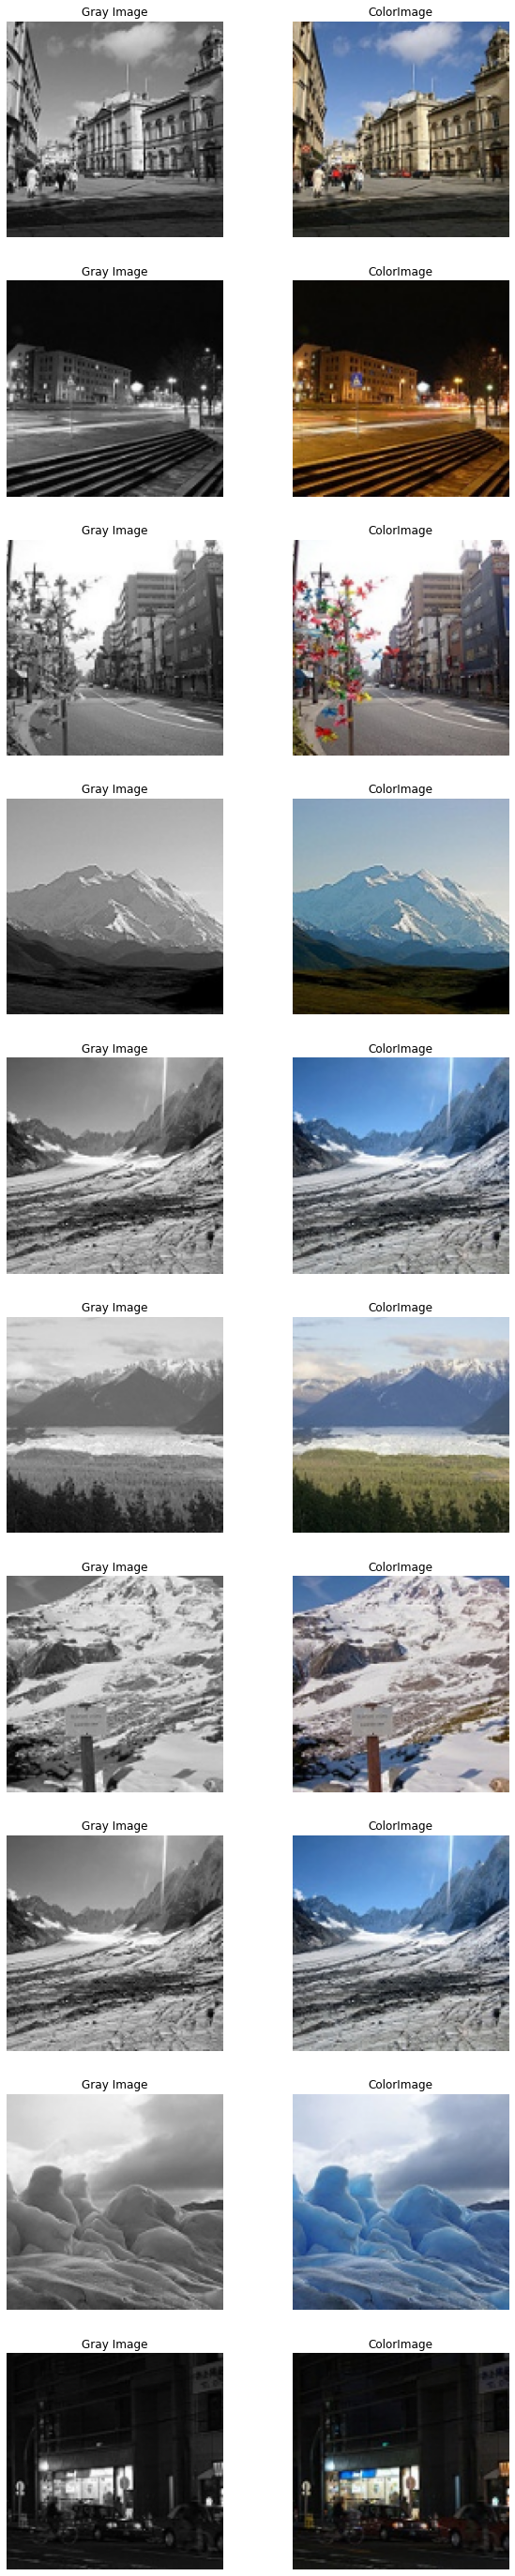

In [ ]:
plt.figure(figsize = (10,50))

i = 0

while i < 20:
    
    x = np.random.randint(0,80)
    
    plt.subplot(10, 2, i+1)
    plt.imshow(X[x]/255.0,'gray')
    plt.axis('off')
    plt.title('Gray Image')
    
    plt.subplot(10, 2, i+2)
    plt.imshow(y[x]/ 255.0)
    plt.axis('off')
    plt.title('ColorImage')
    i += 2
    
plt.show()

In [ ]:
X = (X/127.5) - 1
y = (y/127.5) - 1

In [ ]:
print(X.shape)
print(y.shape)

(100, 128, 128, 3)
(100, 128, 128, 3)


In [ ]:
print(f'Minimum of X : {X.min()}')
print(f'Maximum of X : {X.max()}')

Minimum of X : -1.0
Maximum of X : 1.0


In [ ]:
print(f'Minimum of y : {y.min()}')
print(f'Maximum of y : {y.max()}')

Minimum of y : -1.0
Maximum of y : 1.0


# Train-Test-Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle = False)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(80, 128, 128, 3)
(80, 128, 128, 3)


In [ ]:
print(X_valid.shape)
print(y_valid.shape)

(20, 128, 128, 3)
(20, 128, 128, 3)


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import BatchNormalization
from keras.layers import ZeroPadding2D
from keras.layers import Concatenate
from keras.layers import Activation
from keras.models import Model
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.initializers import RandomNormal
from tensorflow_addons.layers import InstanceNormalization

In [ ]:
'''
Weigth initialization is according to [2], which uses the Gaussian
random distribution with mean of 0 and standard deviation of 0.02.
'''

init = RandomNormal(mean = 0.0, stddev = 0.02)

# PatchGAN (Discriminator)

In [ ]:
def d_block (x_input, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2D(filters, (4, 4),
               strides=strides,
               padding=padding,
               use_bias= False,
               kernel_initializer = init)(x_input)
    
    '''
    SpectralNormalization is wrapped around convolution layer.
    Also, Instance  and  Batch Normalization layers are added.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x


def u_block (x, skip, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2DTranspose(filters, (4, 4),
                        strides=strides,
                        padding=padding,
                        use_bias= False,
                        kernel_initializer = init)(x)
    
    '''
    All the 3 normalizations applied here as well.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = ReLU()(x)
    conc_x = Concatenate()([x , skip])
    
    return conc_x

In [ ]:
def PatchGAN (image_shape) :
    
    genI = Input(shape =  image_shape)
    tarI = Input(shape =  image_shape)
    conc = Concatenate()([genI, tarI])
    
    c064 = d_block(conc, 2**6, 2, 'same', False, False)
    c128 = d_block(c064, 2**7, 2, 'same', False, True )
    c256 = d_block(c128, 2**8, 2, 'same', True , False)
    
    temp = ZeroPadding2D()(c256)
    
    c512 = d_block(temp, 2**9, 1,'valid', True , False)
    
    temp = ZeroPadding2D()(c512)
    
    c001 = Conv2D(2**0, (4,4), strides=1, padding = 'valid', activation = 'sigmoid', kernel_initializer=init)(temp)
    
    model = Model(inputs = [genI, tarI], outputs = c001)
    return model

In [ ]:
d_model = PatchGAN((128,128,3,))
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

# Modified U-net (Generator)

In [ ]:
def mod_Unet () :
    
    srcI = Input(shape = (128,128,3,))
    
    # Contracting path
    
    c064 = d_block(srcI, 2**6, 2, 'same', False, False) # _______________________.
    c128 = d_block(c064, 2**7, 2, 'same', True , False) # ____________________.  .
    c256 = d_block(c128, 2**8, 2, 'same', True , False) # _________________.  .  .
    c512 = d_block(c256, 2**9, 2, 'same', True , False) # ______________.  .  .  .
    d512 = d_block(c512, 2**9, 2, 'same', True , False) # ___________.  .  .  .  .
    e512 = d_block(d512, 2**9, 2, 'same', True , False) # ________.  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Bottleneck layer                                            .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    f512 = d_block(e512, 2**9, 2, 'same', True , False) #         .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Expanding  path                                             .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    u512 = u_block(f512, e512, 2**9, 2, 'same', True, False)# ____.  .  .  .  .  .
    u512 = u_block(u512, d512, 2**9, 2, 'same', True, False)# _______.  .  .  .  .
    u512 = u_block(u512, c512, 2**9, 2, 'same', True, False)# __________.  .  .  .
    u256 = u_block(u512, c256, 2**8, 2, 'same', True, False)# _____________.  .  .
    u128 = u_block(u256, c128, 2**7, 2, 'same', True, False)# ________________.  .
    u064 = u_block(u128, c064, 2**6, 2, 'same', False, True)# ___________________.
    
    genI = Conv2DTranspose(3, (4,4), strides = 2, padding = 'same', activation = 'tanh', kernel_initializer = init)(u064)
    
    model = Model(inputs = srcI, outputs = genI)
    return model

In [ ]:
g_model = mod_Unet()
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 64, 64, 64)   3072        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 64, 64, 64)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 128)  131072      ['leaky_re_lu_4[0][0]']    

# Make tf.dataset

In [ ]:
'''
The information for batch-size appropriate for BW->COLOR transformation
was mentioned as 4 in [1](code source). The optimizer used is Adam with
learningRate of 0.0002, beta1 = 0.5 and beta2 = 0.999 according to [2].
'''

LAMBDA = 100
BATCH_SIZE = 16
BUFFER_SIZE  = 400

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)

# Load Models

In [ ]:
generator = mod_Unet()

discriminator = PatchGAN((128,128,3,)) # (W//1) x (H//1)

In [ ]:
bin_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

# Loss Functions

# Generator Loss

In [ ]:
def gen_loss (dis_gen_output, target_image, gen_output) :
    
    ad_loss = bin_entropy(tf.ones_like (dis_gen_output) ,  dis_gen_output)
    l1_loss = tf.reduce_mean(tf.abs(tf.subtract(target_image,gen_output)))
    
    '''
    Total loss = adversarial +  (LAMBDA*L1)
    '''
    total_loss = ad_loss + (LAMBDA*l1_loss)
    
    return total_loss, ad_loss, l1_loss

# Discriminator Loss

In [ ]:
def dis_loss (dis_gen_output, dis_tar_output) :
    
    gen_loss = bin_entropy(tf.zeros_like(dis_gen_output), dis_gen_output)
    tar_loss = bin_entropy(tf.ones_like (dis_tar_output), dis_tar_output)
    
    total_dis_loss = gen_loss + tar_loss
    return total_dis_loss

# Custom Training

# Images of different resolutions

In [ ]:
img  = cv2.imread('../content/drive/MyDrive/Px2Pix Image Colorisation/landscape Images/color/9.jpg')
img  = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (128,128))
a128 = img_to_array(Image.fromarray(img))

a128/= 255.0

a064 = cv2.resize(a128, (64,64))
a032 = cv2.resize(a064, (32,32))

(-0.5, 31.5, 31.5, -0.5)

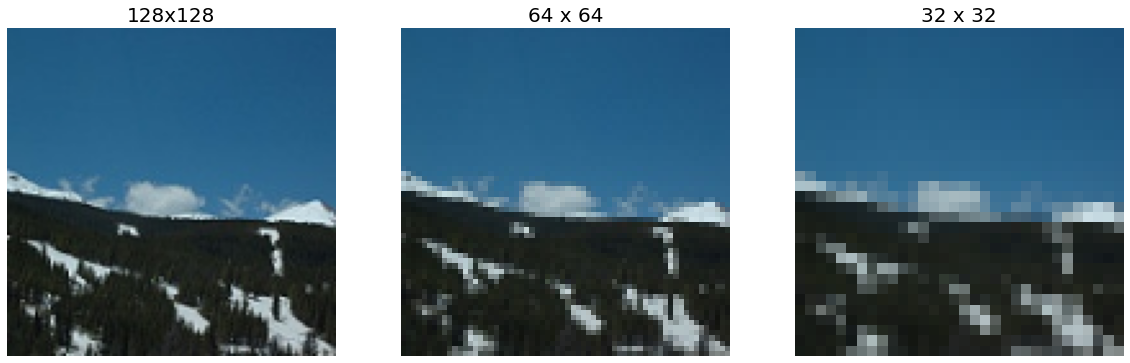

In [ ]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(a128)
plt.title('128x128', fontsize = 20)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(a064)
plt.title('64 x 64', fontsize = 20)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(a032)
plt.title('32 x 32', fontsize = 20)
plt.axis('off')

# Adding Optimizers

In [ ]:
g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)

# Training for each batch

In [ ]:
@tf.function
def train_on_batch (b_w_image, tar_image) :
    
    with tf.GradientTape(persistent = True) as  g :
        
        '''
        Image Tensors
        '''
        gen_image = generator(b_w_image, training=True)
        
        # 128x128
        dis_tar_output_128 = discriminator([b_w_image, tar_image], training = True)
        dis_gen_output_128 = discriminator([b_w_image, gen_image], training = True)
        
        
        tar_image_128 = tar_image
        gen_image_128 = gen_image
        
        tar_image = tf.image.resize(tar_image, [64,64])
        b_w_image = tf.image.resize(b_w_image, [64,64])
        gen_image = tf.image.resize(gen_image, [64,64])
        
        
        '''
        LOSS
        '''
        
        # 128x128
        g_loss_128, _, _ = gen_loss(dis_gen_output_128, tar_image_128, gen_image_128)
        d_loss_128 = dis_loss(dis_gen_output_128, dis_tar_output_128)
        
    
    # compute gradients
    g_gradients = g.gradient(g_loss_128, generator.trainable_variables) # generatorLoss
    
    d_gradients = g.gradient(d_loss_128, discriminator.trainable_variables)   # dis loss 128
    
    
    # apply gradient descent
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

In [ ]:
for global_b_w_image, global_tar_image in train_dataset.take(1) :
    pass

# Model Training

In [ ]:
def fig (b_w_image,gen_image, tar_image) :
    
    plt.figure(figsize = (20, 20))
    
    plt.subplot(1,3,1)
    plt.imshow((b_w_image[0] + 1.0) / 2.0)
    plt.title('Monochrome Image',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow((gen_image[0] + 1.0) / 2.0)
    plt.title('Generate Image',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow((tar_image[0] + 1.0) / 2.0)
    plt.title('Colorized Image',fontsize = 20)
    plt.axis('off')
    
    plt.show()

def fit (EPOCHS = 200) :
    
    for epoch in range(EPOCHS) :
        
        print(f'Epoch {epoch} out of {EPOCHS}')
        
        for n, (b_w_image, tar_image) in train_dataset.enumerate() :
            if n ==  265 :
                print('#....End')
            if n%20 == 0 :
                print('#',end='')
            train_on_batch(b_w_image, tar_image)
        
        if epoch%3  == 0 :
            global_gen_image = generator(global_b_w_image,training = True)
            fig(global_b_w_image,global_gen_image, global_tar_image)

Epoch 0 out of 15
#

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


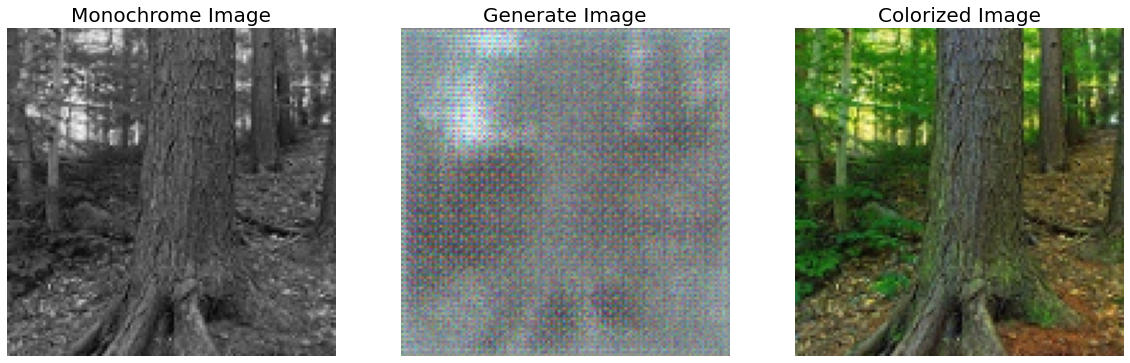

Epoch 1 out of 15
#Epoch 2 out of 15
#Epoch 3 out of 15
#

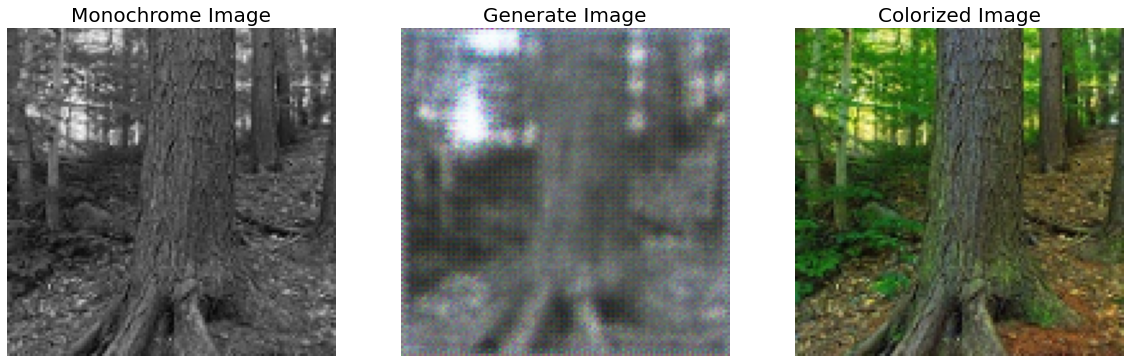

Epoch 4 out of 15
#Epoch 5 out of 15
#Epoch 6 out of 15
#

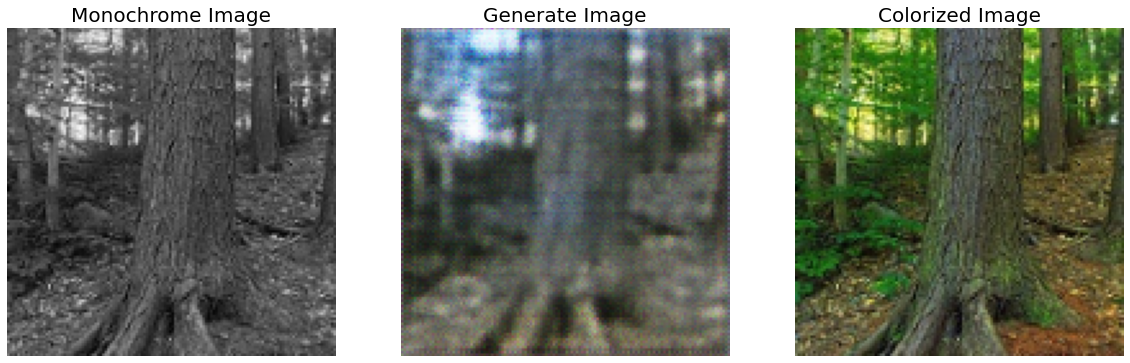

Epoch 7 out of 15
#Epoch 8 out of 15
#Epoch 9 out of 15
#

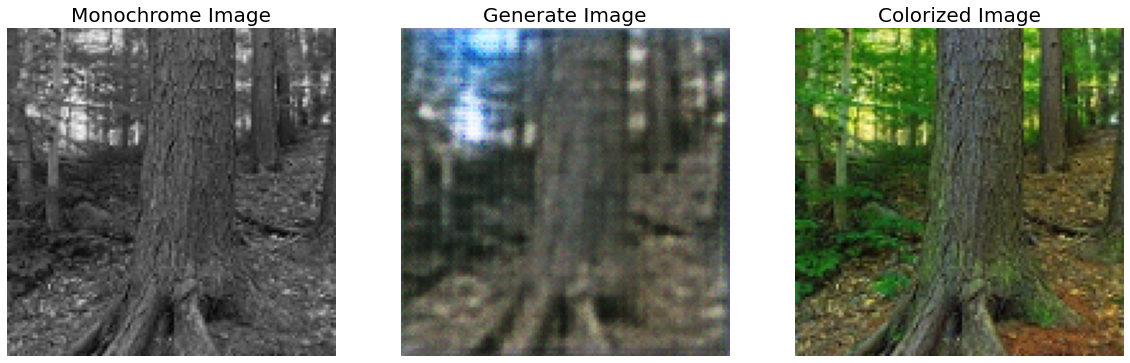

Epoch 10 out of 15
#Epoch 11 out of 15
#Epoch 12 out of 15
#

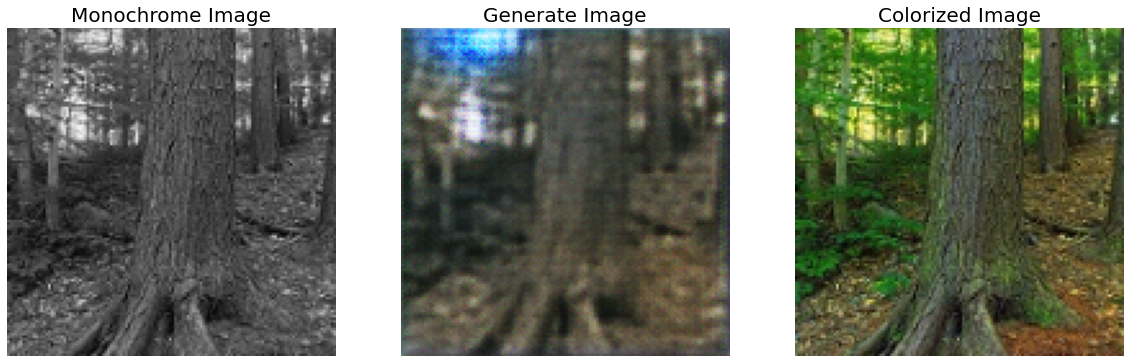

Epoch 13 out of 15
#Epoch 14 out of 15
#

In [ ]:
fit(EPOCHS = 15)

# Model Prediction

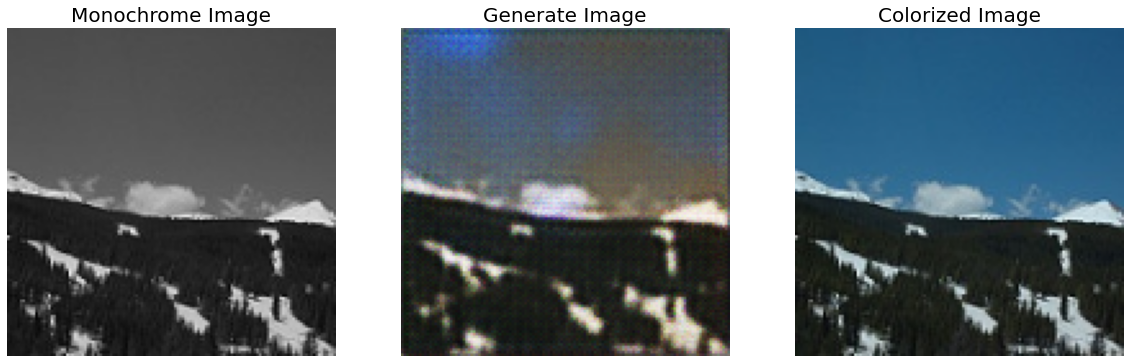

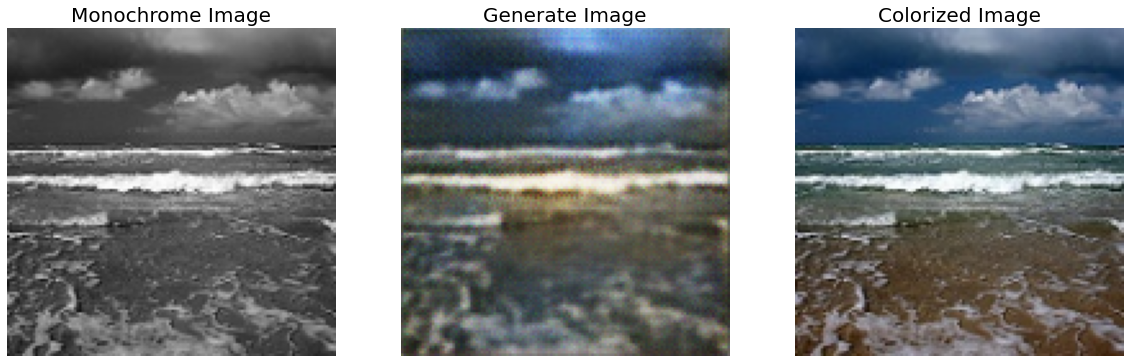

In [ ]:
for b_w_image,tar_image in valid_dataset.take(50) :
    gen_image = generator(b_w_image , training = True)
    fig(b_w_image, gen_image, tar_image)

# Saving the models

In [ ]:
generator.save('./generator.h5')
discriminator.save('./discriminator.h5')